In [5]:
import pandas as pd
import numpy as np
from abc import ABCMeta, abstractmethod

**Visualise** 

- DV01 more negative than PV01 when the rate structure is downard sloping due to convexity,
- DV01 sensitivity per cash flow,
- DV01 difference for upward or downward term structure


In [6]:
class FIProduct(metaclass=ABCMeta):
    @abstractmethod
    def PV(self):
        raise NotImplementedError

In [7]:
class Bond(FIProduct):
    def __init__(self, cash_flows: pd.Series, face_value: float, r: pd.Series):
        self.cf = cash_flows
        self.fv = face_value
        self.r = r
        self.T = cash_flows.index.max()
        self.f = 1.0 / len(np.where(cash_flows.index.values <= 1.0)[0])
        self.c = (cash_flows.iloc[-1] / face_value - 1.0) / self.f
        self.pv = self.PV()

    def PV(self, r=None):
        if r is None:
            r = self.r
        assert len(r) == len(self.cf)
        table = pd.DataFrame(dtype=float)
        table["cf"] = self.cf.values
        table["r"] = r.values
        table["t"] = r.index
        return table.apply(
            lambda row: row["cf"] / (1 + row["r"]) ** row["t"], axis=1
        ).sum()

    def get_yield(self, precision=1e-4):
        func = (
            lambda y: (self.cf.reset_index())
            .apply(
                lambda row: float(row["cash flows"]) / (1 + y) ** (row["schedule"]),
                axis=1,
            )
            .sum()
            - self.pv
        )
        y = find_root(func, precision)
        return y

    def get_price_from_yield(self, y: float):
        return (
            (self.cf.reset_index())
            .apply(
                lambda row: float(row["cash flows"]) / (1 + y) ** (row["schedule"]),
                axis=1,
            )
            .sum()
        )

    def PV01(self, delta_y: float = 1e-4):
        return self.get_price_from_yield(self.get_yield() + delta_y) - self.pv

    def DV01(self, delta_y: float = 1e-4):
        return self.PV(self.r + delta_y) - self.pv

    def plot_cash_flows(self):
        _ = self.cf.plot(
            kind="bar", figsize=(8, 5), title="Cash Flows", grid=True, logy=True
        )

    def DV01_drilldown(self, delta_y=1e-4):
        """Get the rate sensitivity for each maturity"""
        dv01x = []
        for t in self.r.index:
            uptick_t = self.r.copy()
            uptick_t.loc[t] += delta_y
            dv01_ = self.PV(uptick_t) - self.pv
            dv01x.append(dv01_)
        return pd.Series(dv01x, index=self.cf.index)


def generate_bond_cash_flows(face_value, coupon, frequency, maturity):
    n = int(maturity / frequency)
    tx = [k * frequency for k in range(1, n + 1)]
    cash_flows = pd.Series([face_value * coupon / n] * n, index=tx, name="cash flows")
    cash_flows.loc[maturity] += face_value
    cash_flows.index.name = "schedule"
    return cash_flows


def find_root(fun, precision, x0=1.0):
    x = 0.01
    while np.abs(fun(x)) > precision and np.abs(fun(x) - fun(x0)) > precision:
        x, x0 = x - fun(x) * (x0 - x) / (fun(x0) - fun(x)), x
    return x

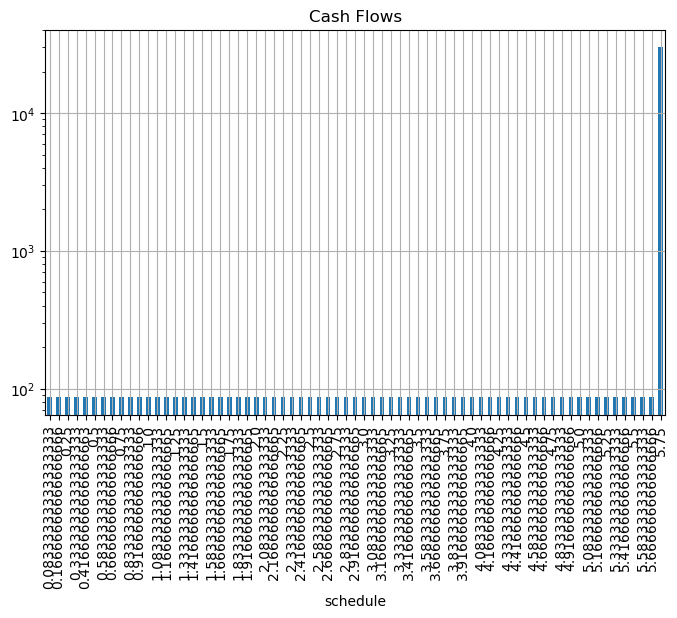

In [25]:
# bond description
fv = 30000
c = 501.0 * 12 / 30000
f = 1.0 / 12
T = 69 / 12

# duration
n = int(T / f)
tx = [k * f for k in range(1, n + 1)]

base = 0.01
trend = 0.001
uptrend_ts = pd.Series(
    [base + trend * np.sqrt(k) for k in range(n)], index=tx, name="forward rate"
)
downtrend_ts = pd.Series(
    [2 * base - trend * np.sqrt(k) for k in range(n)], index=tx, name="forward rate"
)

cash_flows = generate_bond_cash_flows(fv, c, f, T)
bond_up = Bond(cash_flows=cash_flows, face_value=fv, r=uptrend_ts)
bond_up.plot_cash_flows()

<Axes: title={'center': 'Term structures'}>

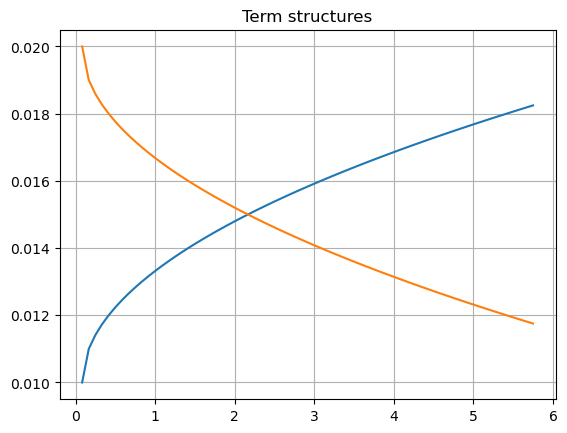

In [26]:
ax = uptrend_ts.plot()
downtrend_ts.plot(ax=ax, grid=True, title="Term structures")

In [27]:
bond_up.PV(), bond_up.get_yield(), bond_up.PV01(), bond_up.DV01()

(32770.58286406057,
 0.018084552850567023,
 -16.886637489929853,
 -16.87894984329978)

In [28]:
bond_down = Bond(cash_flows=cash_flows, face_value=fv, r=downtrend_ts)
bond_down.PV(), bond_down.get_yield(), bond_down.PV01(), bond_down.DV01()

(33834.45283210427,
 0.011911338591047494,
 -17.574901504114678,
 -17.582686683941574)


At short maturities the difference is slight. The difference increases for long maturities.

DV01 and PV01 match for zero-coupon bonds, bullet bonds.



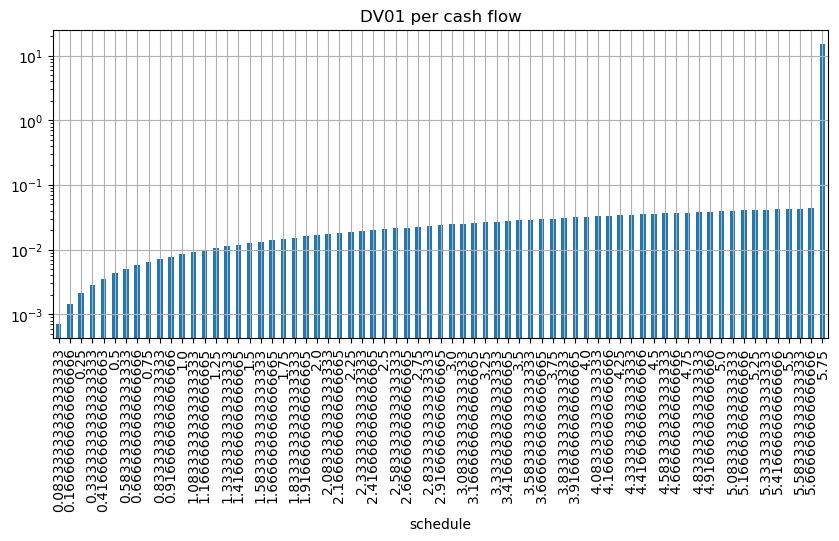

In [44]:
dv01x_up = bond_up.DV01_drilldown().abs()
dv01x_down = bond_down.DV01_drilldown().abs()
ax = dv01x_up.plot(
    kind="bar", logy=True, grid=True, figsize=(10, 4), title="DV01 per cash flow"
)

<Axes: title={'center': 'DV01 difference per cashflow (downward - upward)'}, xlabel='schedule'>

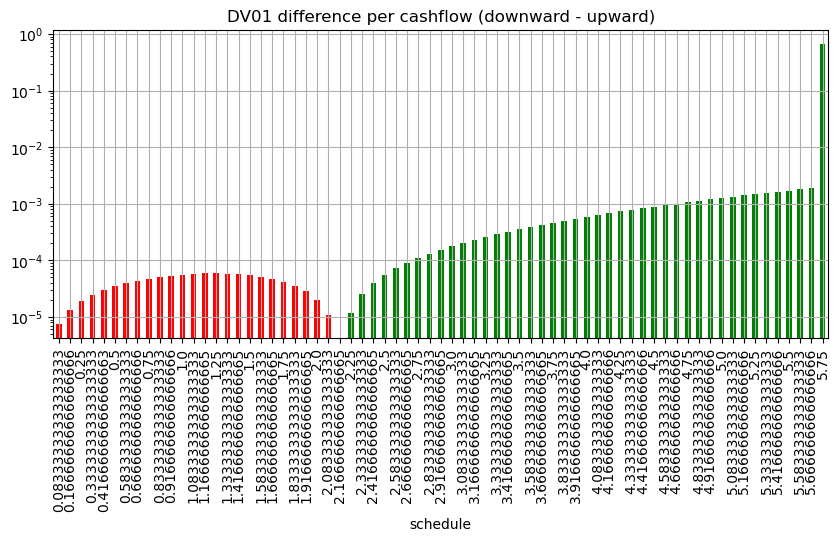

In [43]:
dv01_diff = dv01x_down - dv01x_up
ax = dv01_diff.clip(lower=0.0).plot(
    kind="bar", logy=True, color="green", figsize=(10, 4)
)
dv01_diff.clip(upper=0.0).abs().plot(
    kind="bar",
    logy=True,
    color="red",
    ax=ax,
    grid=True,
    title="DV01 difference per cashflow (downward - upward)",
)

> **yield** = flat rate assumption